In [1]:
import pandas as pd

# Load your CSV file
df = pd.read_csv("/content/drive/MyDrive/Project4/dataset/Constitution Of India.csv")

# Preview
print(df.head())


                                            Articles
0  1. Name and territory of the Union\n(1) India,...
1  1. The territories of the States; the Union te...
2  2. Admission or establishment of new States: P...
3  2A. Sikkim to be associated with the Union Rep...
4  3. Formation of new States and alteration of a...


In [2]:
import re

def clean_and_split_full(df, column='Articles'):
    text = ' '.join(df[column].astype(str).tolist()).lower()
    raw_sentences = re.split(r'[.,;:]', text)

    cleaned_sentences = []
    for sentence in raw_sentences:
        sentence = sentence.strip()
        sentence = re.sub(r'\(\d+[a-z]?\)', '', sentence)
        sentence = re.sub(r'\([a-z]\)', '', sentence)
        sentence = re.sub(r'\b\d+[a-z]?\.', '', sentence)
        sentence = re.sub(r'\b\d+[a-z]?\b', '', sentence)
        sentence = re.sub(r'\s+', ' ', sentence).strip()
        if sentence:
            cleaned_sentences.append(sentence)

    return cleaned_sentences

sentences = clean_and_split_full(df)


In [4]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

# Tokenize using the saved tokenizer
with open("/content/drive/MyDrive/Project4/NextWordModel/tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

total_words = len(tokenizer.word_index) + 1
max_seq_len = 20  # Use the value from training

input_sequences = []

for sentence in sentences:
    token_list = tokenizer.texts_to_sequences([sentence])[0]
    for i in range(1, len(token_list)):
        ngram_seq = token_list[:i+1]
        input_sequences.append(ngram_seq)

input_sequences = pad_sequences(input_sequences, maxlen=max_seq_len, padding='pre')

X = input_sequences[:, :-1]
y_true = input_sequences[:, -1]


In [5]:
from tensorflow.keras.models import load_model
import numpy as np

model = load_model("/content/drive/MyDrive/Project4/NextWordModel/next_word_model.h5")

y_pred_probs = model.predict(X, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)


2105/2105 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step


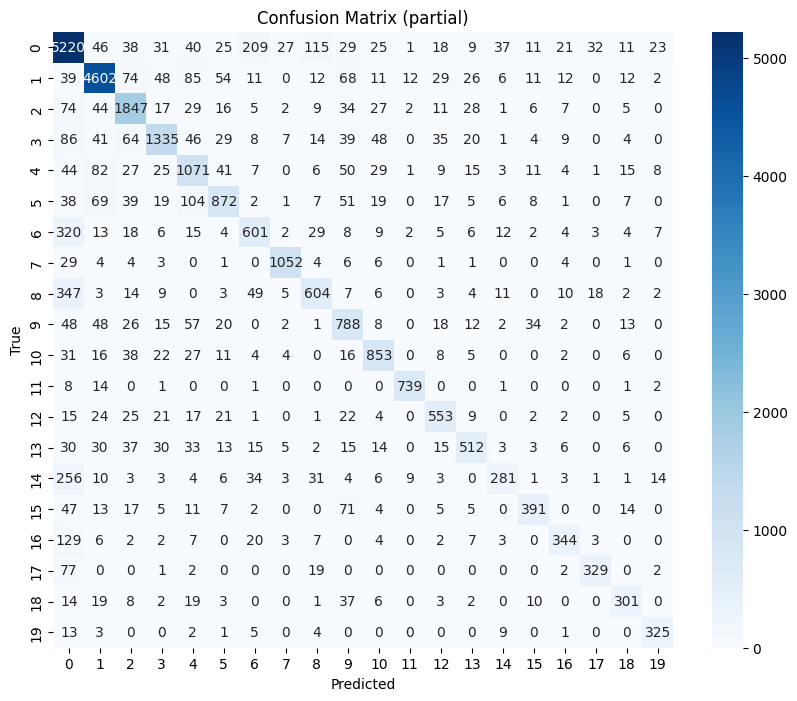

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Classification Report
#print(classification_report(y_true, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm[:20, :20], annot=True, fmt="d", cmap="Blues")  # Slice if matrix is too big
plt.title("Confusion Matrix (partial)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [7]:
top_3 = np.argsort(y_pred_probs, axis=1)[:, -3:]
top_3_accuracy = np.mean([true in top3 for true, top3 in zip(y_true, top_3)])
print("Top-3 Accuracy:", round(top_3_accuracy, 4))


Top-3 Accuracy: 0.7523


In [8]:

loss, acc = model.evaluate(X, to_categorical(y_true, num_classes=total_words))
print(f"Evaluation Accuracy: {acc:.4f}")


2105/2105 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.6222 - loss: 2.6331
Evaluation Accuracy: 0.6190
